# Some info before start
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.


- **TARGET:** Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [734]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Load data and explore it

In [735]:
df = pd.read_csv('data/train.csv')
print('Data shape', df.shape)
df.head()

Data shape (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [736]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


It seems that some data has NaNs (count < than length of the shape)

In [737]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# Target

Balanced Dataset!

<AxesSubplot:xlabel='Transported', ylabel='count'>

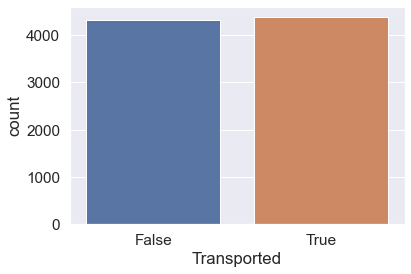

In [738]:
sns.countplot(df.Transported)

## PassengerId 
- A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- Lets get some useful information from here:
    - Split the data into
        - gggg
        - pp

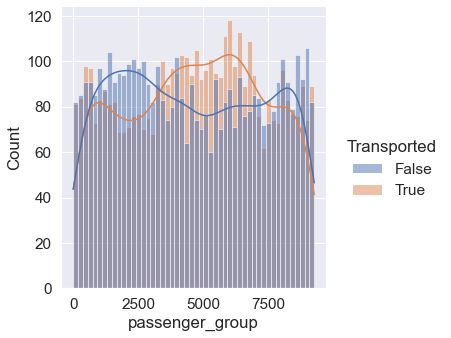

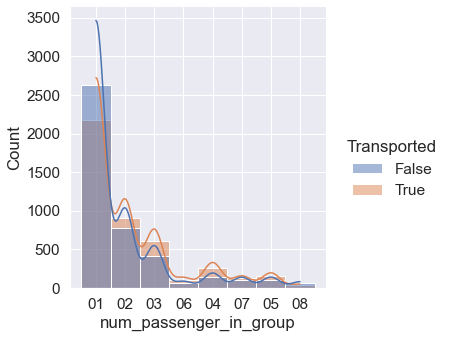

In [739]:
df[['passenger_group', 'passenger_num_in_group']] = df['PassengerId'].str.split('_', expand=True)
df['passenger_group'] = df['passenger_group'].astype(int)

# mirem que passa
sns.displot(data = df, x = 'passenger_group', hue = 'Transported', alpha = 0.5, kde = True, bins = 50)
plt.show()

# new var: number of people per group. It has to be mergde with original one.
df = df.merge(df.groupby('passenger_group')['passenger_num_in_group'].max().reset_index().rename(columns={'passenger_num_in_group':'num_passenger_in_group'}), how = 'left', on = 'passenger_group' )

# mirem que passa
sns.displot(data = df, x = 'num_passenger_in_group', hue = 'Transported', alpha = 0.5, kde = True, bins = 50)
plt.show()

A priori es molt curios, perque sembla que hi ha dos conjunt de 'passenger_group' que tenen comportaments diferents!
- del 500 al 3000 (aprox) --> Transported False predomina
- del 3000 al 6500 aprox --> Transported True domina

Per nombre membres de cada grup:
-  per unitats de 1 persona per grup, sembla que domina no transported

# Name
Creem una nova variable amb Cognoms i Noms

In [740]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,passenger_group,passenger_num_in_group,num_passenger_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,01,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,01,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,01,02
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,02,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,01,01


In [741]:
df[['name', 'surname']] = df['Name'].str.split(' ', expand=True)
df.drop(columns = ['Name'], inplace = True)

# Categorical Variables

In [742]:
# create cabin features
df[['cabin_deck', 'cabin_num','cabin_side']] = df['Cabin'].str.split('/', expand=True)
df['cabin_num'] = df['cabin_num'].astype(float)

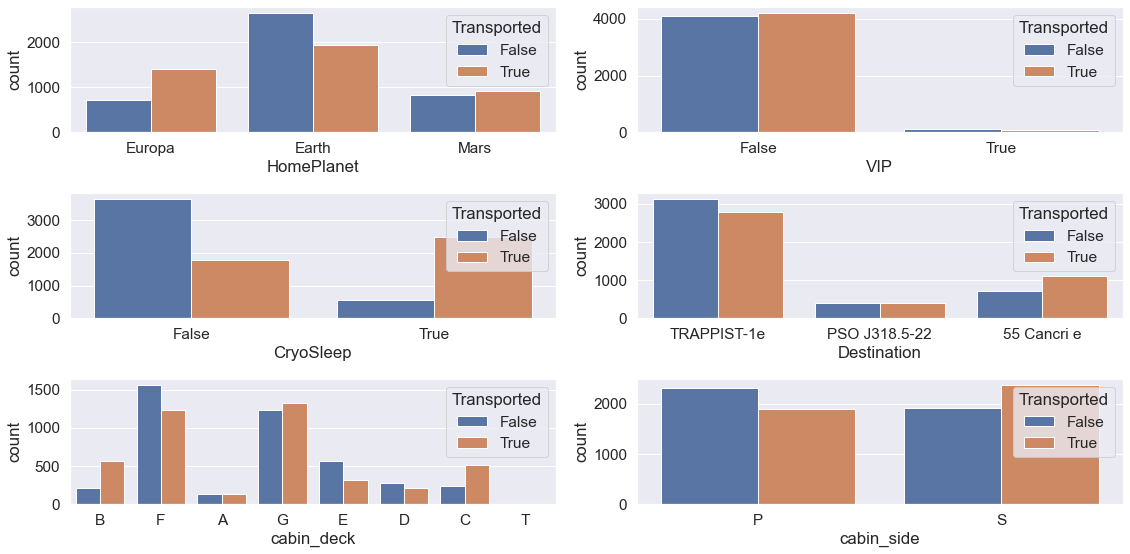

In [743]:


fig, axes = plt.subplots(3, 2, figsize=(16,8))
sns.countplot(df.HomePlanet, hue = df.Transported, ax = axes[0,0])
sns.countplot(df.CryoSleep, hue = df.Transported, ax = axes[1,0])
sns.countplot(df.VIP, hue = df.Transported, ax = axes[0,1])
sns.countplot(df.Destination, hue = df.Transported, ax = axes[1,1])
sns.countplot(df.cabin_deck, hue = df.Transported, ax = axes[2,0])
sns.countplot(df.cabin_side, hue = df.Transported, ax = axes[2,1])
plt.tight_layout()

<Figure size 1440x288 with 0 Axes>

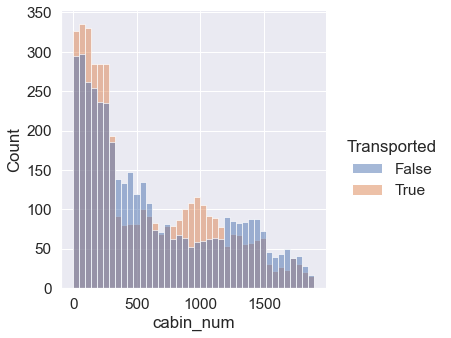

In [744]:
plt.figure(figsize=(20,4))
df['cabin_num'] = df['cabin_num'].astype(float)
sns.displot(data = df, x ='cabin_num', bins = 40, hue = 'Transported')

Sembla que hi ha correlacio clara amb algunes de les variables: 
- HomePlanet (Europe and Mars with higher transported probablity)
- Cryosleep: when True, Transported almost ensured
- Destination: some differences
- VIP: does not seem very significant in this case.....
- cabin_deck: clarissima correlacio
- cabin_side: tb
- cabin_num: la podem tractar com a numerica, ja que es veuen zones de diferencies entre grups...

# Numerical variables

In [745]:
df.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passenger_group,cabin_num
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,-0.009439,-0.132255
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,-0.000346,-0.008986
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,-0.009552,-0.183429
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,0.017397,0.001727
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,-0.005211,-0.131342
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.015432,-0.139080
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,0.021491,-0.045097
passenger_group,-0.009439,-0.000346,-0.009552,0.017397,-0.005211,0.015432,0.021491,1.000000,0.679723
cabin_num,-0.132255,-0.008986,-0.183429,0.001727,-0.131342,-0.139080,-0.045097,0.679723,1.000000


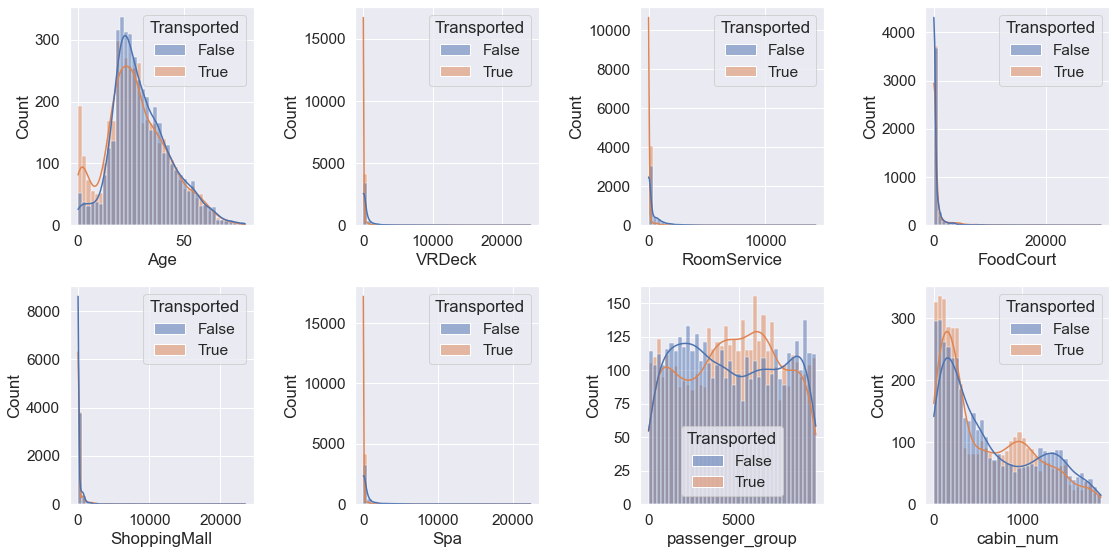

In [746]:
# select the columns to be plotted
cols = ['Age', 'VRDeck','RoomService','FoodCourt','ShoppingMall','Spa','passenger_group','cabin_num']

# create the figure and axes
fig, axes = plt.subplots(2, 4, figsize = (16 , 8))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data = df, x = col, hue ='Transported', kde = True, ax=ax, bins = 40)

fig.tight_layout()
plt.show()

<AxesSubplot:xlabel='Total_expenses', ylabel='Count'>

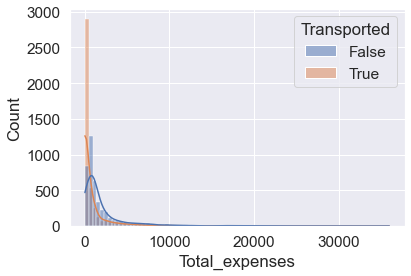

In [747]:
# new variable, with sum of ALL expenses done in the boat
cols = ['VRDeck','RoomService','FoodCourt','ShoppingMall','Spa']
df['Total_expenses'] = df[cols].sum(axis = 1)
sns.histplot(data = df, x = 'Total_expenses', hue ='Transported', kde = True, bins = 80)


<AxesSubplot:xlabel='cabin_side', ylabel='count'>

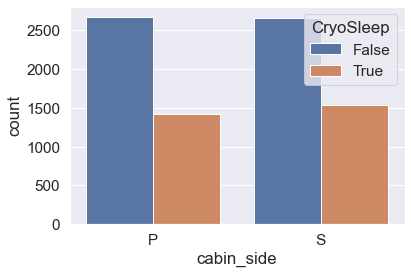

In [749]:
sns.countplot(data = df, x ='cabin_side',  hue = 'CryoSleep')

# Feature Engineering
 - filling Nans:
    - Age: we use the mean value to impute missing vals
    - There are some columns that could be related with 'groups' of people. For instance, same family should come from same planet, go to same planet, .... We use surname and passenger_group to impute.
 - dummy variables
 - prepare model data

In [751]:
############## Fill  NaNs
# Age using mean:
df['Age'].fillna( np.round(df['Age'].mean(),0).astype(int), inplace = True )
# Family related variables.....
df.surname.fillna('Unknown', inplace = True)
cols = ['HomePlanet','CryoSleep','Cabin','Destination','cabin_deck','cabin_num','cabin_side','VIP']
df[cols] = df.groupby(['passenger_group','surname'])[cols].apply(lambda x: x.ffill().bfill())
# Still some NaNs yet...we will just use the most repeated value for each of them
df[cols] = df[cols].fillna(df.mode().iloc[0])


### For the expenses, NaNs to 0.
cols_exp = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df[cols_exp] = df[cols_exp].fillna( value = 0)

###################### Dummy
# Categorical to dummies
cols_to_dummy = ['HomePlanet','CryoSleep','Destination','cabin_deck','cabin_side','VIP']
one_hot = pd.get_dummies(df[cols_to_dummy], columns = cols_to_dummy)


# Numerical. Once spliited we will normalize
cols_to_normalize = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_expenses','cabin_num','num_passenger_in_group','passenger_group']


# create df with data to input to model
df_model = pd.concat([df[cols_to_normalize], one_hot], axis = 1)
print (df_model.shape)

# we are dropping some categorical features that are not giving new information (already in another feature!)
df_model = df_model.drop(columns = ['HomePlanet_Mars','CryoSleep_False','Destination_55 Cancri e','cabin_side_S','VIP_False'])
df_model.head()
print (df_model.shape)


(8693, 30)
(8693, 25)


# Models


Logistic Regression:  0.7849338700402531

Random Forest Classifier:  0.81943645773433

Naive Bayes:  0.7245543415756182

KNeighnours Classifier:  0.7607820586543991
[15:57:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBClassifier:  0.8297872340425532

SVC:  0.7814836112708453

Light GBM:  0.7814836112708453
 ############## Summary Best Model #########################
              precision    recall  f1-score   support

       False       0.81      0.85      0.83       851
        True       0.85      0.81      0.83       888

    accuracy                           0.83      1739
   macro avg       0.83      0.83      0.83      1739
weighted avg       0.83      0.83      0.83      1739



<AxesSubplot:>

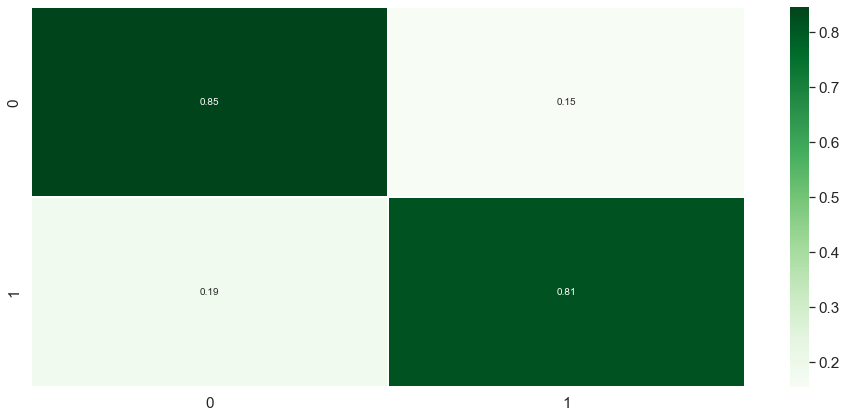

In [752]:
# Split data to test and train
X_train, X_test, y_train, y_test = train_test_split(df_model, df['Transported'], test_size=0.2, random_state = 123)

# Prepare data for the model
sc = preprocessing.MinMaxScaler()
X_train[cols_to_normalize] = sc.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = sc.transform (X_test[cols_to_normalize])

###################### MODELS ####################################
clf = LogisticRegression().fit(X_train, y_train)
pred_y = clf.predict(X_test)
print ('\nLogistic Regression: ', accuracy_score(y_test, pred_y))

rdf = RandomForestClassifier(n_estimators= 2000).fit(X_train, y_train)
pred_y = rdf.predict(X_test)
#print (classification_report(y_test, pred_y))
print ('\nRandom Forest Classifier: ',accuracy_score(y_test, pred_y))


from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
pred_y = gnb.predict(X_test)
print ('\nNaive Bayes: ',accuracy_score(y_test, pred_y))

from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors = 22).fit(X_train, y_train)
pred_y = knc.predict(X_test)
print ('\nKNeighnours Classifier: ',accuracy_score(y_test, pred_y))

from xgboost import XGBClassifier
xgbc = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 12, min_child_weight = 1, subsample = 1, colsample_bytree = 0.4 ).fit(X_train, y_train)
pred_y_xgbc = xgbc.predict(X_test)
print ('\nXGBClassifier: ',accuracy_score(y_test, pred_y_xgbc))

from sklearn.svm import SVC
svc = SVC(kernel = 'poly').fit(X_train, y_train)
pred_y = svc.predict(X_test)
print ('\nSVC: ', accuracy_score(y_test, pred_y))


import lightgbm as lgb
clf = lgb.LGBMClassifier(n_estimators = 400)
pred_y = svc.predict(X_test)
print ('\nLight GBM: ', accuracy_score(y_test, pred_y))



# Best model, show report and confusion matrix
print(' \n############## Summary Best Model #########################')
print (classification_report(y_test, pred_y_xgbc))

# Build the plot
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, pred_y_xgbc)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)


# PREPARE SUBMISSION TO KAGGLE



In [717]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# All together to proceed with feature engineering, etc....
df_train['set'] = 'train'
df_test['set'] = 'test'
df_pre = pd.concat([df_train,df_test], axis = 0)

# New vars....N umber of people per group. It has to be merged with original one.
df_pre[['passenger_group', 'passenger_num_in_group']] = df_pre['PassengerId'].str.split('_', expand=True)
df_pre['passenger_group'] = df_pre['passenger_group'].astype(int)
df_pre = df_pre.merge(df_pre.groupby('passenger_group')['passenger_num_in_group'].max().reset_index().rename(columns={'passenger_num_in_group':'num_passenger_in_group'}), how = 'left', on = 'passenger_group' )

# New vars: name and surname
df_pre[['name', 'surname']] = df_pre['Name'].str.split(' ', expand=True)
df_pre.drop(columns = ['Name'], inplace = True)

# New vars: create cabin features
df_pre[['cabin_deck', 'cabin_num','cabin_side']] = df_pre['Cabin'].str.split('/', expand=True)
df_pre['cabin_num'] = df_pre['cabin_num'].astype(float)

# New vars: sum of ALL expenses done in the boat
cols = ['VRDeck','RoomService','FoodCourt','ShoppingMall','Spa']
df_pre['Total_expenses'] = df_pre[cols].sum(axis = 1)

# Fillnans
df_pre['Age'].fillna( np.round(df_pre['Age'].mean(),0).astype(int), inplace = True )

# group dependant variables....
cols = ['HomePlanet','CryoSleep','Cabin','Destination','cabin_deck','cabin_num','cabin_side','VIP']
df_pre.surname.fillna('Unknown', inplace = True)
df_pre[cols] = df_pre.groupby(['passenger_group','surname'])[cols].apply(lambda x: x.ffill().bfill())
# still some rows with missing nans...... Use most common technique
df_pre[cols] = df_pre[cols].fillna(df_pre.mode().iloc[0])

### For expenses, NaNs to 0
cols_exp = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df_pre[cols_exp] = df_pre[cols_exp].fillna( value = 0)

# Check Nans.
df_pre.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                        0
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported               4277
set                          0
passenger_group              0
passenger_num_in_group       0
num_passenger_in_group       0
name                       294
surname                      0
cabin_deck                   0
cabin_num                    0
cabin_side                   0
Total_expenses               0
dtype: int64

In [719]:
# Categorical to dummies
cols_to_dummy = ['HomePlanet','CryoSleep','Destination','cabin_deck','cabin_side','VIP']
one_hot = pd.get_dummies(df_pre[cols_to_dummy], columns = cols_to_dummy)


# Numerical. Once spliited we will normalize
cols_to_normalize = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_expenses','cabin_num','num_passenger_in_group','passenger_group']

# create df with data to input to model
df_model = pd.concat([df_pre[cols_to_normalize], one_hot, df_pre[['Transported','set']]], axis = 1)
print (df_model.shape)

#df_model = df_model.drop(columns = ['HomePlanet_Mars','CryoSleep_False','Destination_55 Cancri e','cabin_side_S','VIP_False'])
print (df_model.shape)

# Split data to test and train
X_train = df_model[df_model['set'] == 'train'].drop(columns = ['Transported','set'])
y_train = df_model[df_model['set'] == 'train']['Transported']
X_test = df_model[df_model['set'] == 'test'].drop(columns = ['Transported','set'])

# Prepare data for the model
sc = preprocessing.MinMaxScaler()
X_train[cols_to_normalize] = sc.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = sc.transform (X_test[cols_to_normalize])


(12970, 32)
(12970, 32)


After several experiments, the best results have been obtained using an ensemble of models. In this case, an ensemble of:
-  Random Forest
-  XGBoost
-  Logistic Regression
-  Light Boost Classifier
-  SVC

In [725]:
# We train several models
y_train=y_train.astype('int')
rdf = RandomForestClassifier(n_estimators= 2000).fit(X_train, y_train)
xgbc = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 12, min_child_weight = 1, subsample = 1, colsample_bytree = 0.4 ).fit(X_train, y_train)
lgrc = LogisticRegression().fit(X_train, y_train)
lgbC = lgb.LGBMClassifier(n_estimators = 400).fit(X_train, y_train)
svcC = SVC(kernel = 'poly').fit(X_train, y_train)

# save predictions into df
predictions = pd.DataFrame()
predictions['rdf'] = rdf.predict(X_test)
predictions['xgbc'] = xgbc.predict(X_test)
predictions['lgrc'] = lgrc.predict(X_test)
predictions['lgbC'] = lgbC.predict(X_test)
predictions['svcC'] = svcC.predict(X_test)

# most voted
predictions['predictions_most_voted'] = predictions.mode(axis = 1)

# take a look
predictions.head()

[15:39:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [729]:
# Save the CSV to do the submission (0.80757 in Kaggle)
df_submission = pd.DataFrame()
df_submission['PassengerId'] = df_test['PassengerId']
df_submission['Transported'] = 0
df_submission['Transported'] =predictions['predictions_most_voted']

df_submission['Transported'][df_submission['Transported'] == 1] = True
df_submission['Transported'][df_submission['Transported'] == 0] = False

df_submission.to_csv('Ensemble_submission6.csv', index = False)

